In [47]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [48]:
class LSTMAttention(nn.Module):
    def __init__(self, input_size, hidden_size, target_size, num_layers=2):
        super(LSTMAttention, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.attention = nn.Linear(hidden_size, 1)  # Attention layer
        self.fc = nn.Linear(hidden_size, target_size)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)  # Shape: (batch_size, seq_length, hidden_size)
        attn_weights = torch.softmax(
            self.attention(lstm_out), dim=1
        )  # Shape: (batch_size, seq_length, 1)
        context_vector = (lstm_out * attn_weights).sum(
            dim=1
        )  # Weighted sum of LSTM outputs
        out = self.fc(context_vector)  # Final output layer
        return out


In [49]:
df = pd.read_csv("../data/train_imputed_weather_tourism_merged.csv")

In [50]:
df.rename(columns={"Unnamed: 0": "date"}, inplace=True)


In [51]:
df.set_index("date", inplace=True)

df.index = pd.to_datetime(df.index)


In [52]:
# Specify target columns
# Define the target columns
target_columns = ["valeur_NO2", "valeur_CO", "valeur_O3", "valeur_PM10", "valeur_PM25"]

# Define feature_columns as all columns in df except the target columns
feature_columns = [col for col in df.columns if col not in target_columns]

In [57]:
# Normalize data
from sklearn.preprocessing import MinMaxScaler

scaler_features = MinMaxScaler()
scaler_target = MinMaxScaler()

df[feature_columns] = scaler_features.fit_transform(df[feature_columns])

df[target_columns] = scaler_target.fit_transform(df[target_columns])


In [66]:
def create_sequences(feature_data, target_data, seq_length=24):
    sequences = []
    targets = []
    for i in range(len(feature_data) - seq_length):
        seq = feature_data[i : i + seq_length]  # Use only feature data for sequences
        target = target_data[i + seq_length]  # Use target data for targets
        sequences.append(seq)
        targets.append(target)
    return np.array(sequences), np.array(targets)


# Generate sequences and targets
feature_data = df[feature_columns].values  # Only feature columns
target_data = df[target_columns].values  # Only target columns
sequences, targets = create_sequences(feature_data, target_data, seq_length=24)


In [67]:
# Define train-test split ratio
train_size = int(0.8 * len(sequences))

# Split sequences and targets into training and test sets
train_sequences = sequences[:train_size]
train_targets = targets[:train_size]

test_sequences = sequences[train_size:]
test_targets = targets[train_size:]


In [70]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [71]:
print("Training Sequences Shape:", train_sequences.shape)
print("Training Targets Shape:", train_targets.shape)
print("Test Sequences Shape:", test_sequences.shape)
print("Test Targets Shape:", test_targets.shape)


Training Sequences Shape: (32773, 24, 44)
Training Targets Shape: (32773, 5)
Test Sequences Shape: (8194, 24, 44)
Test Targets Shape: (8194, 5)


In [72]:
from torch.utils.data import DataLoader, TensorDataset


In [73]:
# Convert to PyTorch tensors
train_sequences = torch.tensor(train_sequences, dtype=torch.float32)
train_targets = torch.tensor(train_targets, dtype=torch.float32)

test_sequences = torch.tensor(test_sequences, dtype=torch.float32)
test_targets = torch.tensor(test_targets, dtype=torch.float32)


In [74]:
# Create TensorDataset objects for training and test data
train_data = TensorDataset(train_sequences, train_targets)
test_data = TensorDataset(test_sequences, test_targets)

# Define batch size
batch_size = 64

# Create DataLoaders
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)


In [75]:
# Model parameters
input_size = len(feature_columns)
hidden_size = 64
target_size = len(target_columns)
num_layers = 2
learning_rate = 0.001
epochs = 50


In [76]:
# Initialize the model and move it to the chosen device
model = LSTMAttention(
    input_size=input_size,
    hidden_size=hidden_size,
    target_size=target_size,
    num_layers=num_layers,
)
model = model.to(device)


In [77]:
import torch.optim as optim

In [78]:
# Define the loss function and optimizer
criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

In [79]:
# Training loop
for epoch in range(epochs):
    model.train()  # Set model to training mode
    train_loss = 0

    # Loop over batches
    for x_batch, y_batch in train_loader:
        # Move data to the same device as the model
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        # Forward pass
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)

        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(
            model.parameters(), max_norm=1.0
        )  # Optional: Clip gradients
        optimizer.step()

        # Accumulate loss for monitoring
        train_loss += loss.item() * x_batch.size(0)

    # Average loss over the dataset
    train_loss /= len(train_loader.dataset)

    # Step the scheduler
    scheduler.step()

    # Print loss for this epoch
    print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}")

# Training complete
print("Training complete!")


Epoch [1/50], Train Loss: 0.0421
Epoch [2/50], Train Loss: 0.0379
Epoch [3/50], Train Loss: 0.0360
Epoch [4/50], Train Loss: 0.0346
Epoch [5/50], Train Loss: 0.0332
Epoch [6/50], Train Loss: 0.0320
Epoch [7/50], Train Loss: 0.0312
Epoch [8/50], Train Loss: 0.0305
Epoch [9/50], Train Loss: 0.0299
Epoch [10/50], Train Loss: 0.0295
Epoch [11/50], Train Loss: 0.0288
Epoch [12/50], Train Loss: 0.0282
Epoch [13/50], Train Loss: 0.0280
Epoch [14/50], Train Loss: 0.0278
Epoch [15/50], Train Loss: 0.0276
Epoch [16/50], Train Loss: 0.0275
Epoch [17/50], Train Loss: 0.0273
Epoch [18/50], Train Loss: 0.0271
Epoch [19/50], Train Loss: 0.0269
Epoch [20/50], Train Loss: 0.0266
Epoch [21/50], Train Loss: 0.0264
Epoch [22/50], Train Loss: 0.0261
Epoch [23/50], Train Loss: 0.0259
Epoch [24/50], Train Loss: 0.0257
Epoch [25/50], Train Loss: 0.0255
Epoch [26/50], Train Loss: 0.0254
Epoch [27/50], Train Loss: 0.0252
Epoch [28/50], Train Loss: 0.0251
Epoch [29/50], Train Loss: 0.0250
Epoch [30/50], Train Lo

In [80]:
from sklearn.metrics import mean_absolute_error

model.eval()  # Set model to evaluation mode
test_loss = 0
predictions = []
actuals = []

# Disable gradient tracking
with torch.no_grad():
    for x_batch, y_batch in test_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)
        test_loss += loss.item() * x_batch.size(0)

        # Append predictions and actuals
        predictions.append(outputs.cpu().numpy())
        actuals.append(y_batch.cpu().numpy())

# Concatenate all predictions and actuals
predictions = np.concatenate(predictions)
actuals = np.concatenate(actuals)

# Inverse transform the predictions and actuals
predictions = scaler_target.inverse_transform(predictions)
actuals = scaler_target.inverse_transform(actuals)

# Calculate MAE
mae = mean_absolute_error(actuals, predictions)
print(f"Test MAE: {mae:.2f}")


Test MAE: 5.26


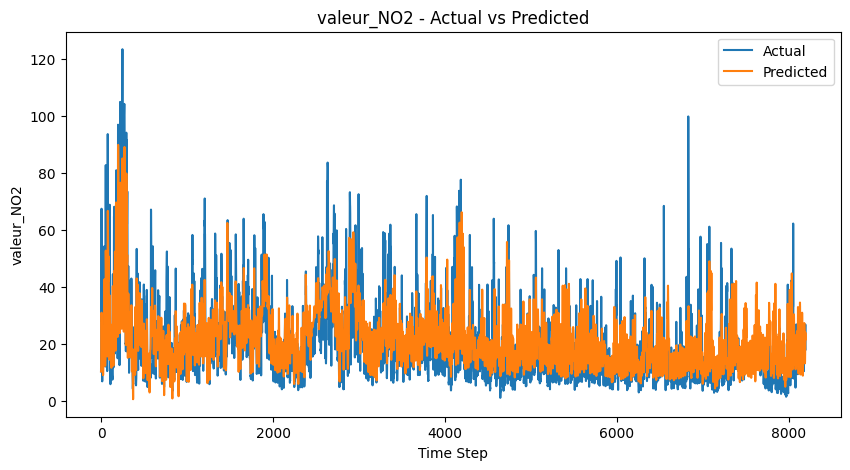

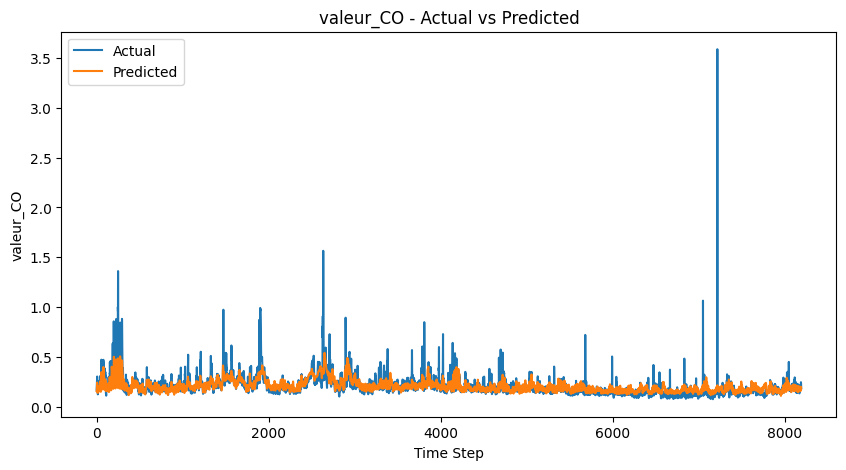

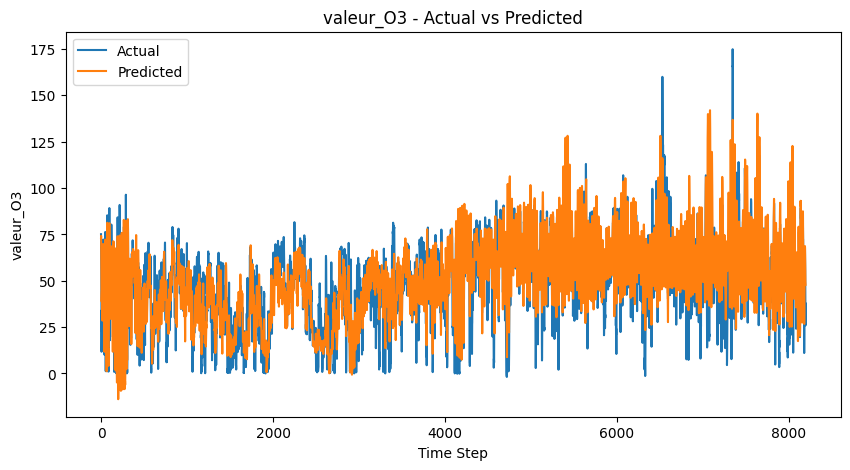

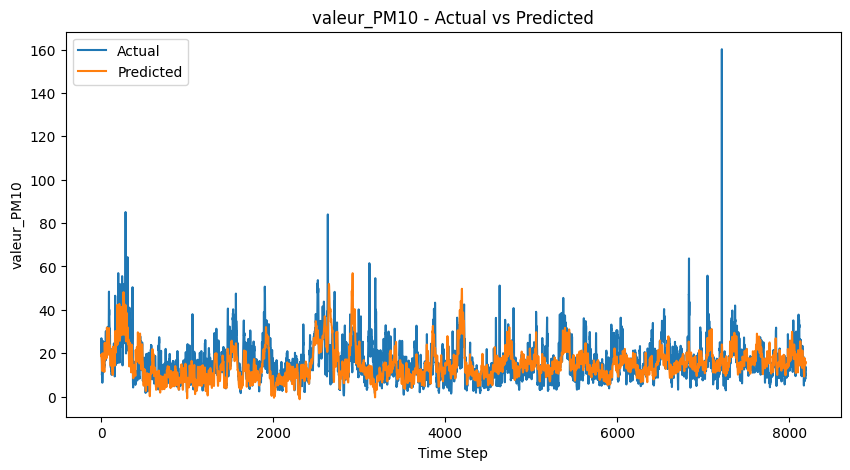

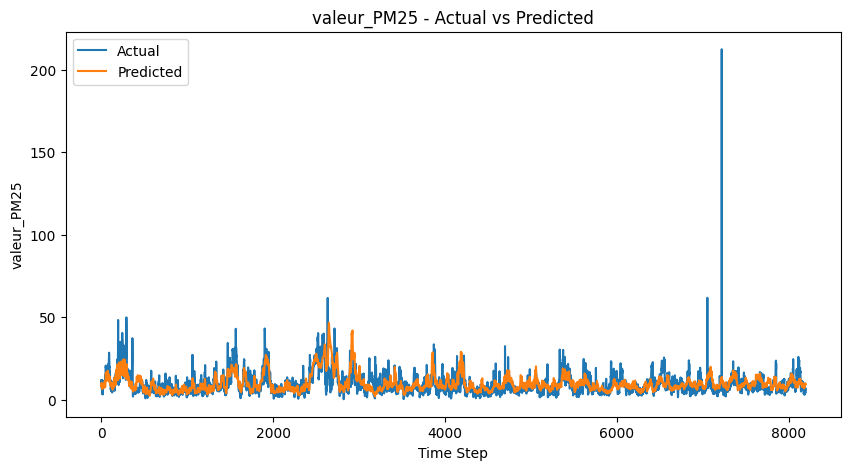

In [81]:
import matplotlib.pyplot as plt

# Plot predictions vs. actuals for each target variable
for i, col in enumerate(target_columns):
    plt.figure(figsize=(10, 5))
    plt.plot(actuals[:, i], label="Actual")
    plt.plot(predictions[:, i], label="Predicted")
    plt.title(f"{col} - Actual vs Predicted")
    plt.xlabel("Time Step")
    plt.ylabel(col)
    plt.legend()
    plt.show()


### Predictions

In [83]:
df_unknown = pd.read_csv("../data/test_weather_tourism_merged_24H.csv")

df_unknown.rename(columns={"Unnamed: 0": "date"}, inplace=True)

df_unknown.set_index("date", inplace=True)

In [84]:
df_unknown.index = pd.to_datetime(df_unknown.index)

df_unknown.rename_axis("id", inplace=True)


In [86]:
df_unknown[feature_columns] = scaler_features.transform(df_unknown[feature_columns])

feature_data_unknown = df_unknown[feature_columns].values

sequences_unknown = []
for i in range(len(feature_data_unknown) - 24):
    seq = feature_data_unknown[i : i + 24]
    sequences_unknown.append(seq)

# Convert to PyTorch tensors
sequences_unknown = torch.tensor(sequences_unknown, dtype=torch.float32)

# Create TensorDataset object for unknown data
unknown_data = TensorDataset(sequences_unknown)

# Create DataLoader
unknown_loader = DataLoader(unknown_data, batch_size=batch_size, shuffle=False)

model.eval()  # Set model to evaluation mode
predictions_unknown = []

# Disable gradient tracking

with torch.no_grad():
    for x_batch in unknown_loader:
        x_batch = x_batch[0].to(device)  # Only sequences are needed
        outputs = model(x_batch)
        predictions_unknown.append(outputs.cpu().numpy())

# Concatenate all predictions
predictions_unknown = np.concatenate(predictions_unknown)

# Inverse transform the predictions
predictions_unknown = scaler_target.inverse_transform(predictions_unknown)

# Create a DataFrame with the predictions
df_predictions = pd.DataFrame(predictions_unknown, columns=target_columns)

In [88]:
df_predictions.index = df_unknown.index[24:]

In [90]:
df_predictions.reset_index(inplace=True)


In [91]:
df_predictions

,id,valeur_NO2,valeur_CO,valeur_O3,valeur_PM10,valeur_PM25
0,2024-09-03 23:00:00,30.907240,0.202983,81.201202,1.710470,0.455061
1,2024-09-04 00:00:00,31.025278,0.203447,80.764854,1.655447,0.425243
2,2024-09-04 01:00:00,31.232595,0.204307,79.973640,1.525043,0.392655
3,2024-09-04 02:00:00,31.544930,0.205638,78.852608,1.323452,0.370152
4,2024-09-04 03:00:00,31.703579,0.206345,78.360252,1.218471,0.377591
...,...,...,...,...,...,...
499,2024-09-24 18:00:00,40.527988,0.245158,38.240337,-0.925540,-0.172478
500,2024-09-24 19:00:00,40.511036,0.245075,38.297199,-0.923900,-0.181102
501,2024-09-24 20:00:00,40.502754,0.245026,38.340862,-0.921156,-0.184729
502,2024-09-24 21:00:00,40.491589,0.244958,38.374573,-0.918826,-0.192123


In [92]:
df_predictions["id"] = df_predictions["id"].dt.strftime("%Y-%m-%d %H")


In [93]:
df_predictions.to_csv("../submissions/predictions_LSTM_attention.csv", index=False)
